In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

### Reflect Tables into SQLAlchemy ORM

In [2]:
# Create Engine to DB
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [3]:
# explorer db to get more info about data
inspector = inspect(engine)

# get table names
print(inspector.get_table_names())

['measurement', 'station']


In [4]:
# get column names and their data types for 'measurement' table
measurement_columns = inspector.get_columns('measurement')
print("Measurment table column's names:")
for col in measurement_columns:
    print(col['name'], col['type'])


Measurment table column's names:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [5]:
# get column names and their data types for 'station' table

station_columns = inspector.get_columns('station')
print("Station table column's names")
for col in station_columns:
    print(col['name'], col['type'])

Station table column's names
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
# Reflect db 
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# reflect tables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
session = Session(engine)

### Exploratory Climate Analysis

In [9]:
# calculate start day as the latest day from observation
start_day_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
start_day_point =dt.datetime.strptime(start_day_point[0], "%Y-%m-%d")
start_day_point = start_day_point.date()

# calculate one yaer ago from start day
one_year_ago = start_day_point - dt.timedelta(days=365)

# get data from db for one year
prcp_by_date = session.query(Measurement.date, Measurement.prcp)\
                     .filter(Measurement.date <= start_day_point)\
                     .filter(Measurement.date >= one_year_ago).order_by(Measurement.date).all()  

In [10]:
prcp_by_date_df = pd.DataFrame(prcp_by_date, columns=['date', 'prcp'])
prcp_by_date_df.set_index('date', inplace=True)
prcp_by_date_df.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


In [11]:
# remove rows with NaN 
prcp_by_date_df.dropna(inplace=True)


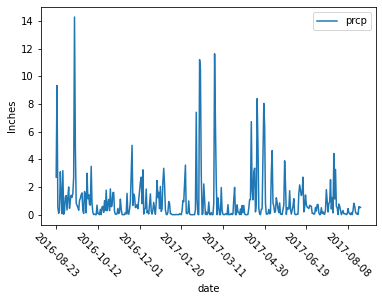

In [13]:
#group by by date
prcp_by_date_sum_df = prcp_by_date_df.groupby(by='date').sum()
prcp_by_date_sum_df.head(30)
# generate a plot
prcp_by_date_sum_df.plot(rot=-45)
plt.ylabel('Inches')
plt.show()

In [14]:
# Summary statistics
prcp_by_date_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Total number of stations
station_count = session.query(func.count(Station.name)).all()
print(f"The count of available stations are {station_count[0][0]}")

The count of available stations are 9


In [16]:
# Station activity
station_activity = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Min, Max and Avg temprature that was observed on the most active station 
obs = session.query(func.min(Measurement.tobs)\
                            , func.max(Measurement.tobs)\
                            , func.avg(Measurement.tobs))\
                            .filter(Measurement.station == station_activity[0][0]).all()
obs

[(54.0, 85.0, 71.66378066378067)]

In [18]:
temp_obs_data = session.query(Measurement.date, Measurement.tobs)\
                    .filter(Measurement.date <= start_day_point)\
                    .filter(Measurement.date >= one_year_ago)\
                    .filter(Measurement.station == station_activity[0][0]).all()

temp_obs_data

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [19]:
temp_obs_df = pd.DataFrame(temp_obs_data)
temp_obs_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


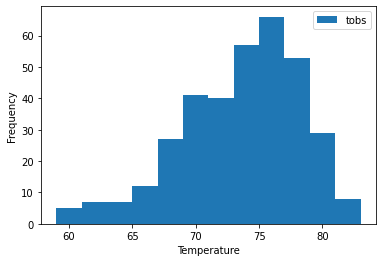

In [20]:
temp_obs_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.show()

### Temperature Analysis

In [21]:
from scipy import stats

In [22]:
june_str = '07'
ret_june_tobs = session.query(func.avg(Measurement.tobs), func.strftime("%Y", Measurement.date))\
                .filter(func.strftime("%d", Measurement.date) == june_str)\
                .group_by(func.strftime("%Y",Measurement.date)).all()
ret_june_tobs

[(71.81521739130434, '2010'),
 (71.38541666666667, '2011'),
 (72.39024390243902, '2012'),
 (72.59550561797752, '2013'),
 (72.76136363636364, '2014'),
 (72.67567567567568, '2015'),
 (72.91025641025641, '2016'),
 (73.91666666666667, '2017')]

In [23]:
june_tobs = pd.DataFrame(ret_june_tobs, columns=['Avg_June', 'Year'])
june_tobs

,Avg_June,Year
0,71.815217,2010
1,71.385417,2011
2,72.390244,2012
3,72.595506,2013
4,72.761364,2014
5,72.675676,2015
6,72.910256,2016
7,73.916667,2017


In [24]:
december_str = '12'
ret_december_tobs = session.query(func.avg(Measurement.tobs), func.strftime("%Y", Measurement.date))\
                .filter(func.strftime("%d", Measurement.date) == december_str)\
                .group_by(func.strftime("%Y",Measurement.date)).all()

ret_december_tobs

[(71.96666666666667, '2010'),
 (73.08045977011494, '2011'),
 (72.76136363636364, '2012'),
 (71.75, '2013'),
 (73.11235955056179, '2014'),
 (73.01204819277109, '2015'),
 (74.07692307692308, '2016'),
 (74.5, '2017')]

In [25]:
dec_tobs = pd.DataFrame(ret_december_tobs, columns=['Avg_December', 'Year'])
dec_tobs

,Avg_December,Year
0,71.966667,2010
1,73.080460,2011
2,72.761364,2012
3,71.750000,2013
4,73.112360,2014
5,73.012048,2015
6,74.076923,2016
7,74.500000,2017


In [26]:
stats.ttest_ind(june_tobs['Avg_June'], dec_tobs['Avg_December'])

Ttest_indResult(statistic=-1.1218620865925195, pvalue=0.28079453519886655)

There is no significant difference between temperature on Hawaii in June and December.

### Temperature Analysis 2

In [27]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# create DF with min, avg and max temperature for trip
min_avg_max = pd.DataFrame(calc_temps('2016-01-15', '2016-01-23'), columns=['TMIN', 'TAVG', 'TMAX'])
min_avg_max

,TMIN,TAVG,TMAX
0,61.0,69.326923,77.0


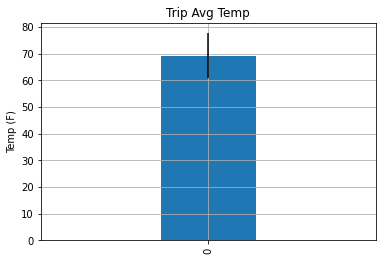

In [29]:
# bar chart 
min_avg_max['TAVG'].plot.bar(yerr=[min_avg_max['TAVG'] - min_avg_max['TMIN']\
                                   , min_avg_max['TMAX'] - min_avg_max['TAVG']], width=0.2)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid()
plt.show()


### Daily Rainfall Average

In [30]:
session.query(Measurement.station\
              , Station.name\
              , func.sum(Measurement.prcp)\
              , Station.latitude\
              , Station.longitude\
              , Station.elevation)\
        .filter(Measurement.station == Station.station)\
        .filter(Measurement.date >= '2017-01-15')\
        .filter(Measurement.date <= '2017-01-23')\
        .group_by(Measurement.station)\
        .order_by(Measurement.prcp.desc()
                  , Station.name.desc()
                  , Station.latitude.desc()
                  , Station.longitude.desc(), Station.elevation)\
        .all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  1.73,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.16, 21.2716, -157.8168, 3.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.15000000000000002,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00517948', 'PEARL CITY, HI US', 0.0, 21.3934, -157.9751, 11.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 0.13, 21.4234, -157.8015, 14.6),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.15,
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.02,
  21.5213,
  -157.8374,
  7.0)]

In [31]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
trip_dates = []

trip_start = dt.datetime.strptime('2021-01-15', '%Y-%m-%d')
trip_start = trip_start.date()

i = 0
trip_len = 9
while len(trip_dates) != trip_len:
    next_day = trip_start + dt.timedelta(days=i)
    trip_dates.append(next_day)
    i += 1
print(*trip_dates)

2021-01-15 2021-01-16 2021-01-17 2021-01-18 2021-01-19 2021-01-20 2021-01-21 2021-01-22 2021-01-23


In [33]:
dates = []

for i in range(len(trip_dates)):
    d = trip_dates[i].day
    m = trip_dates[i].month
    if m < 10:
        no_year = f"0{m}-{d}"
    else:
        no_year = f"{m}-{d}"
    dates.append(no_year)
    
dates

['01-15',
 '01-16',
 '01-17',
 '01-18',
 '01-19',
 '01-20',
 '01-21',
 '01-22',
 '01-23']

In [34]:
# Daily normals
daily_norm = []
for i in range(len(dates)):
    daily_norm.append(list(daily_normals(dates[i])[0]))
daily_norm  

[[56.0, 69.31372549019608, 78.0],
 [54.0, 68.62962962962963, 80.0],
 [61.0, 69.07407407407408, 76.0],
 [57.0, 68.63157894736842, 77.0],
 [60.0, 68.26315789473684, 78.0],
 [61.0, 68.86666666666666, 78.0],
 [61.0, 70.14545454545454, 76.0],
 [60.0, 69.26415094339623, 76.0],
 [57.0, 69.50909090909092, 79.0]]

In [35]:
rainfall_df = pd.DataFrame(daily_norm, columns=['tmin', 'tavg', 'tmax']\
                       , index=pd.date_range(start='2018/01/15', end='2018/01/23', freq='D'))
rainfall_df

,tmin,tavg,tmax
2018-01-15,56.0,69.313725,78.0
2018-01-16,54.0,68.629630,80.0
2018-01-17,61.0,69.074074,76.0
2018-01-18,57.0,68.631579,77.0
2018-01-19,60.0,68.263158,78.0
2018-01-20,61.0,68.866667,78.0
2018-01-21,61.0,70.145455,76.0
2018-01-22,60.0,69.264151,76.0
2018-01-23,57.0,69.509091,79.0


In [36]:
rainfall_df.index

DatetimeIndex(['2018-01-15', '2018-01-16', '2018-01-17', '2018-01-18',
               '2018-01-19', '2018-01-20', '2018-01-21', '2018-01-22',
               '2018-01-23'],
              dtype='datetime64[ns]', freq='D')

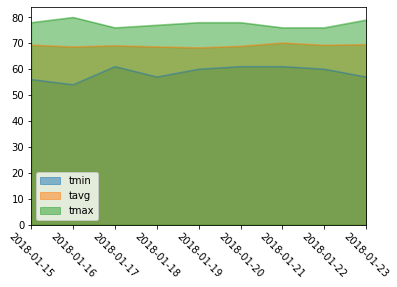

In [37]:
rainfall_df.plot.area(stacked=False)
ticks = [x.strftime("%Y-%m-%d") for x in rainfall_df.index]

plt.xticks(ticks, ticks, rotation=-45)
plt.show()